## Brain Tumor - CNN Image Classification

### Importing libraries

In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import KFold


### Oranizing paths

In [2]:
# Define the path to the uploaded zip file and the target directory
target_dir = 'dataset/'


# Explore the structure of the 'Training' and 'Testing' directories
training_dir = os.path.join(target_dir, 'Training/')
testing_dir = os.path.join(target_dir, 'Testing/')

# List the contents of the Training and Testing directories
training_contents = os.listdir(training_dir)
testing_contents = os.listdir(testing_dir)

# Explore the number of images in each class for Training and Testing sets
training_images_count = {
    folder: len(os.listdir(os.path.join(training_dir, folder)))
    for folder in training_contents if os.path.isdir(os.path.join(training_dir, folder))
}

testing_images_count = {
    folder: len(os.listdir(os.path.join(testing_dir, folder)))
    for folder in testing_contents if os.path.isdir(os.path.join(testing_dir, folder))
}

training_images_count, testing_images_count


({'pituitary': 1457, 'notumor': 1595, 'glioma': 1321, 'meningioma': 1339},
 {'pituitary': 300, 'notumor': 405, 'glioma': 300, 'meningioma': 306})

### Exploring and visualizing the dataset
This dataset contains 7023 images of human brain MRI images which are classified into 4 classes: 
- glioma 
- meningioma 
- no tumor and 
- pituitary

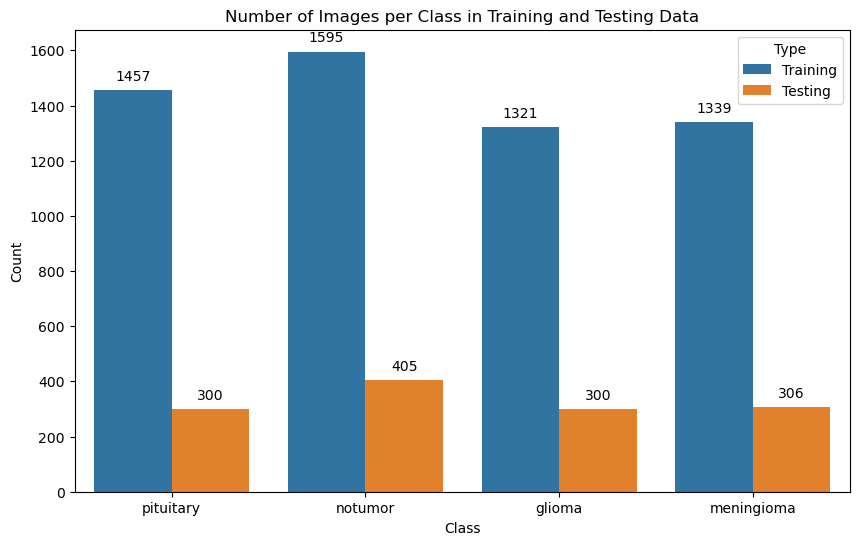

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Convert dictionaries to DataFrame
df_train = pd.DataFrame(list(training_images_count.items()), columns=['Class', 'Count'])
df_train['Type'] = 'Training'

df_test = pd.DataFrame(list(testing_images_count.items()), columns=['Class', 'Count'])
df_test['Type'] = 'Testing'

# Concatenate training and testing dataframes
df_combined = pd.concat([df_train, df_test])

# Generate the bar plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=df_combined, x='Class', y='Count', hue='Type')
plt.title('Number of Images per Class in Training and Testing Data')
plt.ylabel('Count')
plt.xlabel('Class')

# Annotate each bar with the count
for p in ax.patches:
    height = int(p.get_height())
    ax.annotate(f'{height}', 
                (p.get_x() + p.get_width() / 2., height), 
                ha='center', va='center', 
                xytext=(0, 10), 
                textcoords='offset points')

plt.show()


#### Data Processing

In [9]:
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    'dataset/Training/',
    target_size=(150, 150),  # Image resizing
    batch_size=32,
    class_mode='categorical',
    subset='training')

validation_generator = train_datagen.flow_from_directory(
    'dataset/Training/',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='validation')

test_generator = test_datagen.flow_from_directory(
    'dataset/Testing/',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    shuffle=False)


Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


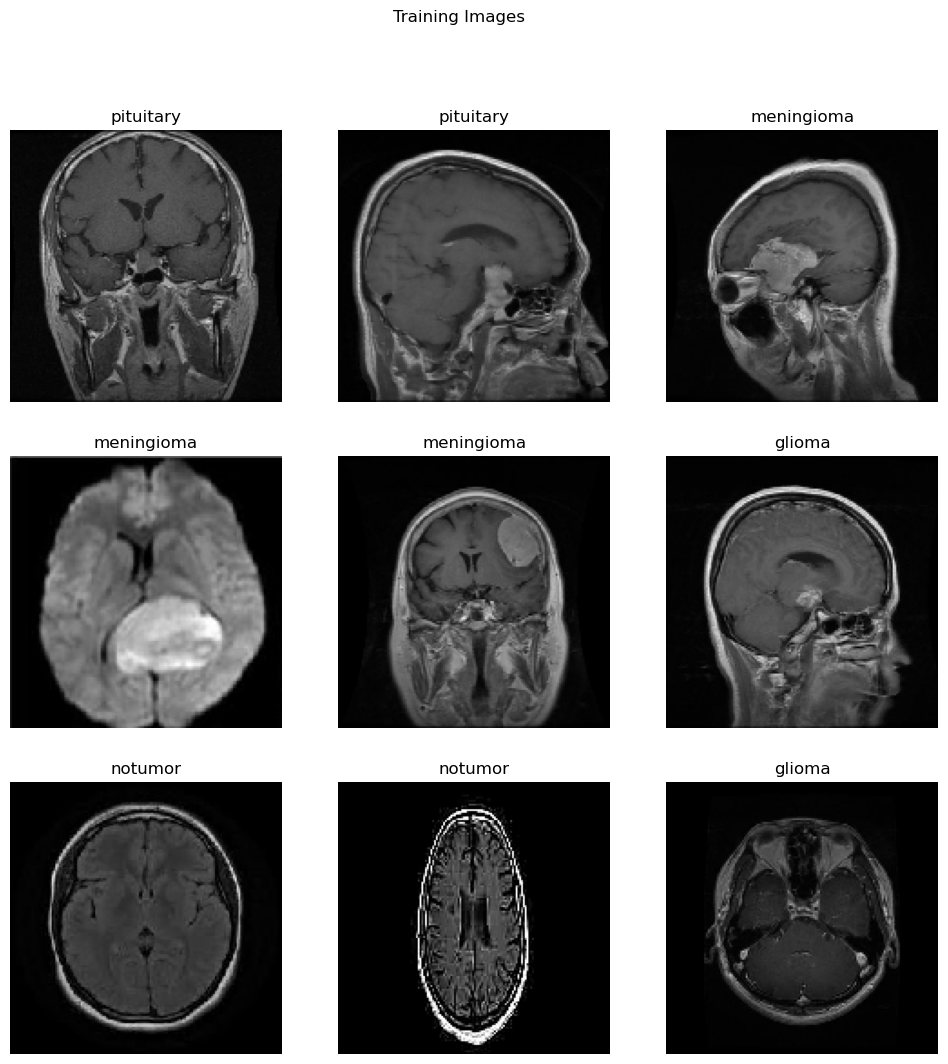

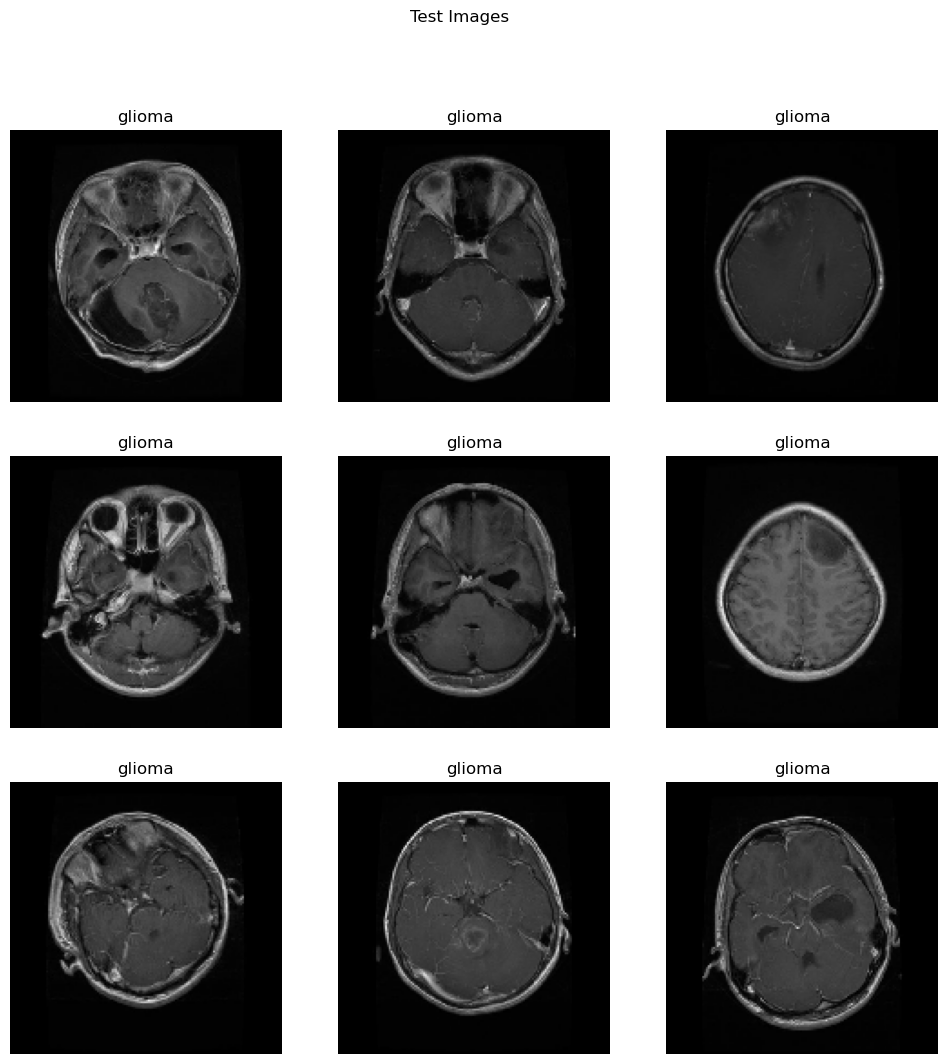

In [10]:
import matplotlib.pyplot as plt

def plot_images(generator, title):
    # Get a batch of images and labels from the generator
    images, labels = next(generator)
    
    # Get class labels from generator
    class_labels = list(generator.class_indices.keys())

    plt.figure(figsize=(12, 12))
    for i in range(9):  # Display the first 9 images from the batch
        plt.subplot(3, 3, i + 1)
        image = images[i]
        label = class_labels[np.argmax(labels[i])]  # Get the label (as class name) for the image
        plt.imshow(image)
        plt.title(label)
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

# Plot images from the train generator
plot_images(train_generator, 'Training Images')

# Plot images from the test generator
plot_images(test_generator, 'Test Images')


### Model architecture

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

def create_model():
    model = Sequential([
        
        # input (1st conv)
        Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
        MaxPooling2D(2, 2),
        
        # 2nd conv
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        
        # 3rd conv
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        
        # 4th conv
        Conv2D(256, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        
        Flatten(),
        
        # fully connected 
        Dense(512, activation='relu'),
        
        # output
        Dense(4, activation='softmax')
    ])
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model



In [14]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam

model_1 = create_model()

history_1 = model_1.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=50,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size)


Epoch 1/50
142/142 [==============================] - 24s 168ms/step - loss: 0.6924 - accuracy: 0.7081 - val_loss: 0.8577 - val_accuracy: 0.6759
Epoch 2/50
142/142 [==============================] - 24s 170ms/step - loss: 0.3396 - accuracy: 0.8735 - val_loss: 0.8739 - val_accuracy: 0.6946
Epoch 3/50
142/142 [==============================] - 25s 174ms/step - loss: 0.2313 - accuracy: 0.9121 - val_loss: 0.6804 - val_accuracy: 0.7839
Epoch 4/50
142/142 [==============================] - 25s 174ms/step - loss: 0.1613 - accuracy: 0.9401 - val_loss: 0.7551 - val_accuracy: 0.8018
Epoch 5/50
142/142 [==============================] - 25s 174ms/step - loss: 0.1051 - accuracy: 0.9592 - val_loss: 0.8884 - val_accuracy: 0.7973
Epoch 6/50
142/142 [==============================] - 25s 174ms/step - loss: 0.0694 - accuracy: 0.9736 - val_loss: 0.7678 - val_accuracy: 0.8179
Epoch 7/50
142/142 [==============================] - 25s 176ms/step - loss: 0.0491 - accuracy: 0.9830 - val_loss: 0.9013 - val_ac

### Model evaluation

40/40 [==============================] - 2s 48ms/step - loss: 0.7377 - accuracy: 0.9414
Test Accuracy: 94.14%


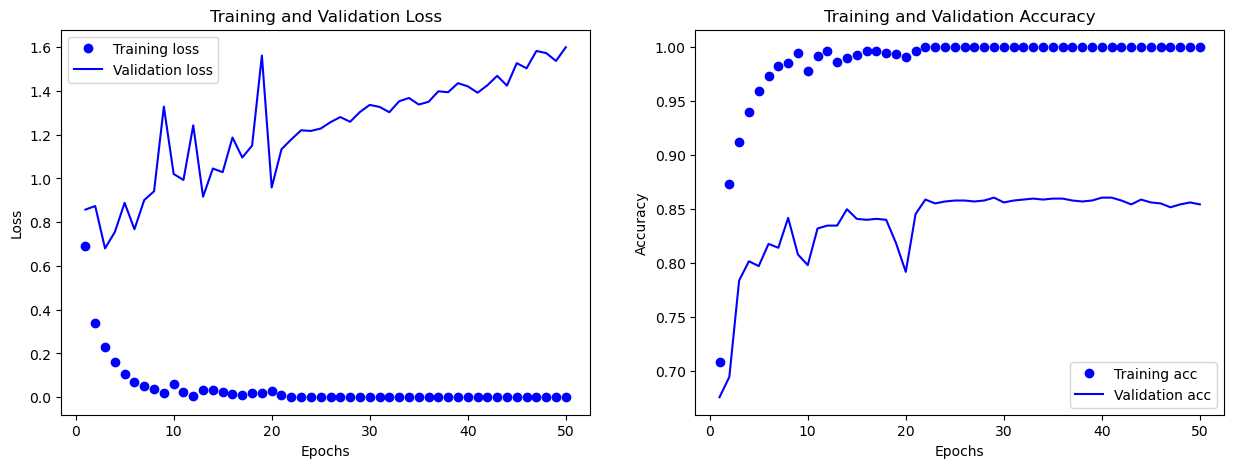

In [16]:
# Evaluate the model on the test data
test_loss, test_accuracy = model_1.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)

# Print out the accuracy
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# 'history' is the history callback from the model fitting process
import matplotlib.pyplot as plt

# Plot the training and validation accuracy and loss at each epoch
loss = history_1.history['loss']
val_loss = history_1.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.figure(figsize=(15, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
accuracy = history_1.history['accuracy']
val_accuracy = history_1.history['val_accuracy']
plt.plot(epochs, accuracy, 'bo', label='Training acc')
plt.plot(epochs, val_accuracy, 'b', label='Validation acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


### Performance metrics

In [21]:
# Evaluate the model
test_loss, test_acc = model_1.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print(f'Test accuracy: {test_acc * 100:.2f}%')

train_loss, train_acc = model_1.evaluate(train_generator)
print(f"Train Accuracy: {train_acc * 100:.2f}%")

40/40 [==============================] - 2s 47ms/step - loss: 0.7377 - accuracy: 0.9414
Test accuracy: 94.14%
143/143 [==============================] - 7s 47ms/step - loss: 1.0622e-06 - accuracy: 1.0000
Train Accuracy: 100.00%


41/41 [==============================] - 2s 47ms/step


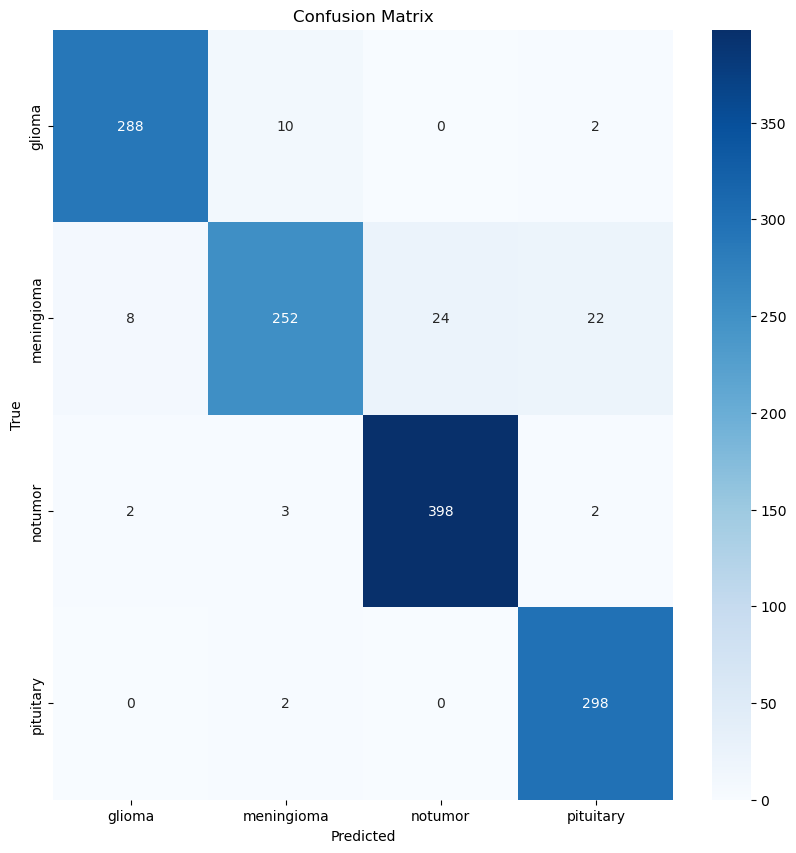

In [24]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Reset the test_generator before making predictions to ensure alignment
test_generator.reset()

# Generate predictions
predictions = model_1.predict(test_generator, steps=np.ceil(test_generator.samples / test_generator.batch_size))

# Convert predictions to class indices
predicted_classes = np.argmax(predictions, axis=1)

# Ensure the true_classes array aligns with the predicted_classes
true_classes = test_generator.classes[:len(predicted_classes)]

# Adjust as necessary based on how your classes are defined
class_labels = list(test_generator.class_indices.keys())  

cm = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [26]:
from sklearn.metrics import classification_report

print(classification_report(true_classes, predicted_classes))


              precision    recall  f1-score   support

           0       0.97      0.96      0.96       300
           1       0.94      0.82      0.88       306
           2       0.94      0.98      0.96       405
           3       0.92      0.99      0.96       300

    accuracy                           0.94      1311
   macro avg       0.94      0.94      0.94      1311
weighted avg       0.94      0.94      0.94      1311



### Image augmentation

In [114]:
train_datagen_2 = ImageDataGenerator(
    rescale=1./255, 
    validation_split=0.2)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator_2 = train_datagen_2.flow_from_directory(
    'dataset/Training/',
    target_size=(150, 150),  # Image resizing
    batch_size=32,
    class_mode='categorical',
    subset='training')

validation_generator = train_datagen_2.flow_from_directory(
    'dataset/Training/',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='validation')

test_generator = test_datagen.flow_from_directory(
    'dataset/Testing/',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    shuffle=False)

Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


### Hyperparameter tuning

In [115]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam

In [127]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras import regularizers

def create_model(learning_rate=1e-3):
    model = Sequential([
        
        # input (1st conv)
        Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(150, 150, 3)),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        
        # 2nd conv
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        
        # 3rd conv
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        
        # 4th conv
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        
        # 5th conv
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        
        Flatten(),
        
        # fully connected 
        Dense(512, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.001)),
        BatchNormalization(),
        Dropout(0.6),
        
        # output
        Dense(4, activation='softmax')
    ])
    
    model.compile(optimizer=Adam(learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [128]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight

filepath="weights.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor="val_accuracy", verbose=1, save_best_only=True, mode="max")

model_2 = create_model(learning_rate=0.001)

model_2.summary()

# adjust the learning rate dynamically based on validation loss improvements
reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.1,
    min_delta=0.0001,
    patience=5,
    min_lr=1e-4,
    verbose=1)

# Initialize early stopping
early_stopping = EarlyStopping(
   monitor='val_accuracy',     # Metric to monitor
   patience=10,                # Number of epochs to wait for improvement
   verbose=1,                  # Logging
   restore_best_weights=True   # Restore model weights from the epoch with the best value of the monitored metric
)

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator_2.classes),
    y=train_generator_2.classes)

class_weight_dict = dict(enumerate(class_weights))

history_2 = model_2.fit(
    train_generator_2,
    steps_per_epoch=train_generator_2.samples // train_generator_2.batch_size,
    epochs=100,
    validation_data=validation_generator,
    class_weight=class_weight_dict,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=[reduce_lr, checkpoint, early_stopping])

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_105 (Conv2D)         (None, 150, 150, 32)      896       
                                                                 
 batch_normalization_119 (B  (None, 150, 150, 32)      128       
 atchNormalization)                                              
                                                                 
 max_pooling2d_105 (MaxPool  (None, 75, 75, 32)        0         
 ing2D)                                                          
                                                                 
 conv2d_106 (Conv2D)         (None, 75, 75, 64)        18496     
                                                                 
 batch_normalization_120 (B  (None, 75, 75, 64)        256       
 atchNormalization)                                              
                                                     

/Users/blambodh/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


142/142 [==============================] - ETA: 0s - loss: 12.9228 - accuracy: 0.8123
Epoch 2: val_accuracy improved from 0.25714 to 0.27232, saving model to weights.hdf5
142/142 [==============================] - 28s 197ms/step - loss: 12.9228 - accuracy: 0.8123 - val_loss: 12.8274 - val_accuracy: 0.2723 - lr: 0.0010
Epoch 3/100
142/142 [==============================] - ETA: 0s - loss: 11.1051 - accuracy: 0.8515
Epoch 3: val_accuracy improved from 0.27232 to 0.29821, saving model to weights.hdf5
142/142 [==============================] - 28s 196ms/step - loss: 11.1051 - accuracy: 0.8515 - val_loss: 12.2607 - val_accuracy: 0.2982 - lr: 0.0010
Epoch 4/100
142/142 [==============================] - ETA: 0s - loss: 9.4678 - accuracy: 0.8870
Epoch 4: val_accuracy improved from 0.29821 to 0.60982, saving model to weights.hdf5
142/142 [==============================] - 28s 200ms/step - loss: 9.4678 - accuracy: 0.8870 - val_loss: 8.2211 - val_accuracy: 0.6098 - lr: 0.0010
Epoch 5/100
142/142

40/40 [==============================] - 2s 48ms/step - loss: 0.7523 - accuracy: 0.9508
Test Accuracy: 95.08%


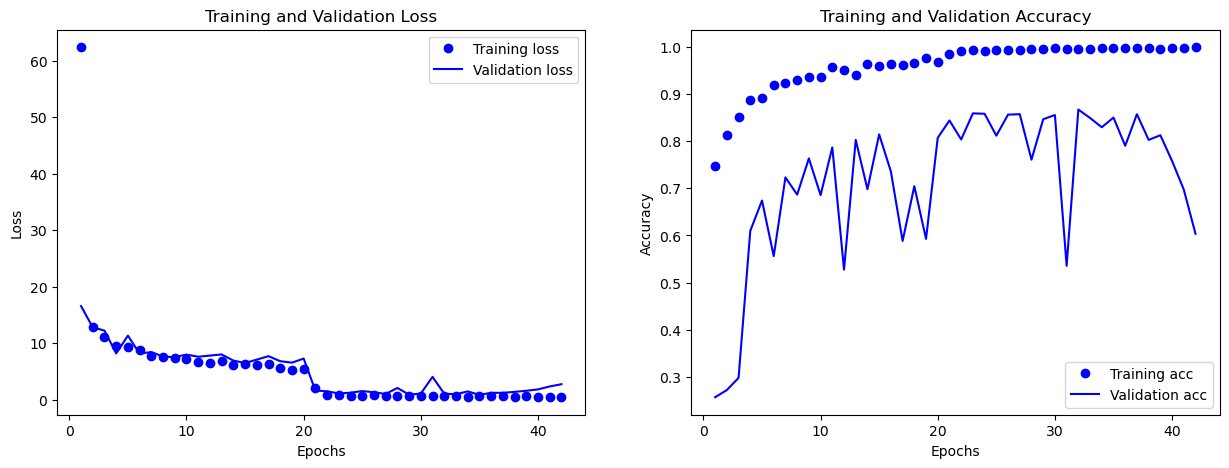

In [129]:
import matplotlib.pyplot as plt

# Evaluate the model on the test data
test_loss, test_accuracy = model_2.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)

# Print out the accuracy
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Plot the training and validation accuracy and loss at each epoch
loss = history_2.history['loss']
val_loss = history_2.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.figure(figsize=(15, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
accuracy = history_2.history['accuracy']
val_accuracy = history_2.history['val_accuracy']
plt.plot(epochs, accuracy, 'bo', label='Training acc')
plt.plot(epochs, val_accuracy, 'b', label='Validation acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()



In [130]:
# Evaluate the model
test_loss, test_acc = model_2.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print(f'Test accuracy: {test_acc * 100:.2f}%')

train_loss, train_acc = model_2.evaluate(train_generator_2)
print(f"Train Accuracy: {train_acc * 100:.2f}%")

40/40 [==============================] - 2s 48ms/step - loss: 0.7523 - accuracy: 0.9508
Test accuracy: 95.08%
143/143 [==============================] - 7s 48ms/step - loss: 0.5974 - accuracy: 0.9996
Train Accuracy: 99.96%


41/41 [==============================] - 2s 49ms/step


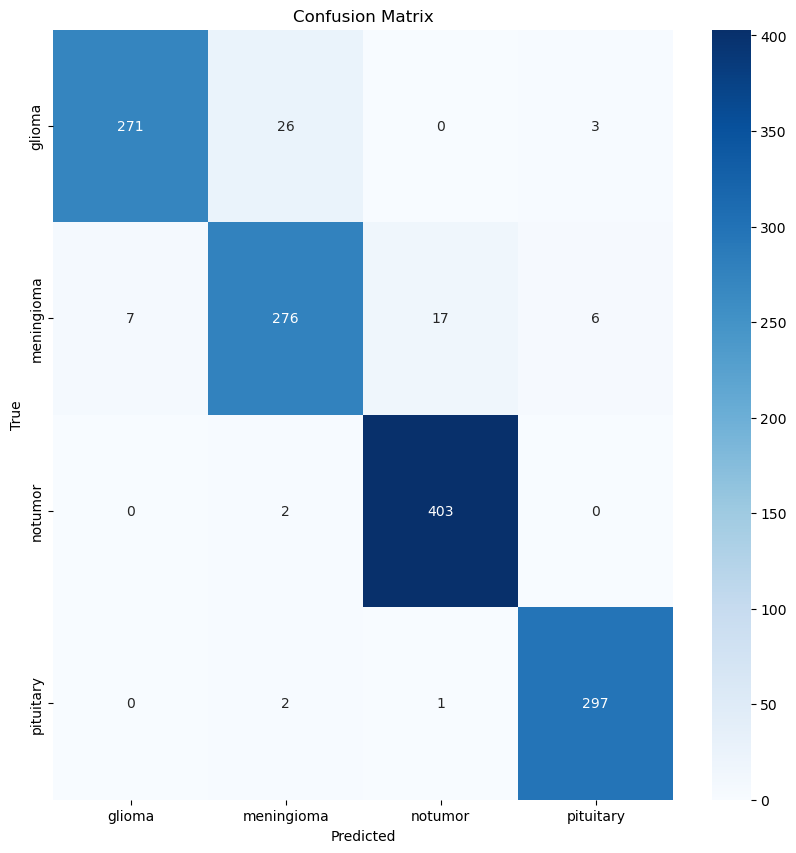

In [131]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Reset the test_generator before making predictions to ensure alignment
test_generator.reset()

# Generate predictions
predictions = model_2.predict(test_generator, steps=np.ceil(test_generator.samples / test_generator.batch_size))

# Convert predictions to class indices
predicted_classes = np.argmax(predictions, axis=1)

# Ensure the true_classes array aligns with the predicted_classes
true_classes = test_generator.classes[:len(predicted_classes)]

# Adjust as necessary based on how your classes are defined
class_labels = list(test_generator.class_indices.keys())  

cm = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [132]:
from sklearn.metrics import classification_report

print(classification_report(true_classes, predicted_classes))

              precision    recall  f1-score   support

           0       0.97      0.90      0.94       300
           1       0.90      0.90      0.90       306
           2       0.96      1.00      0.98       405
           3       0.97      0.99      0.98       300

    accuracy                           0.95      1311
   macro avg       0.95      0.95      0.95      1311
weighted avg       0.95      0.95      0.95      1311



### Transfer learning

In [140]:
from tensorflow.keras.applications import ResNet152V2
resnet_base_model = ResNet152V2(input_shape=(150, 150, 3), include_top=False, weights='imagenet')

# Transfer learning network
model_tl = Sequential()
model_tl.add(resnet_base_model)
model_tl.add(Flatten())

model_tl.add(Dense(1024,activation="relu"))
model_tl.add(BatchNormalization())
model_tl.add(Dropout(rate=0.5))

model_tl.add(Dense(128,activation="relu"))
model_tl.add(BatchNormalization())
model_tl.add(Dropout(rate=0.4))

model_tl.add(Dense(4, activation='softmax'))

In [136]:
model_tl.summary()

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152v2 (Functional)    (None, 5, 5, 2048)        58331648  
                                                                 
 flatten_25 (Flatten)        (None, 51200)             0         
                                                                 
 dense_50 (Dense)            (None, 1024)              52429824  
                                                                 
 batch_normalization_125 (B  (None, 1024)              4096      
 atchNormalization)                                              
                                                                 
 dropout_86 (Dropout)        (None, 1024)              0         
                                                                 
 dense_51 (Dense)            (None, 128)               131200    
                                                     

In [137]:
#freeze initial layers of the network
resnet_base_model.trainable = False

In [143]:
model_tl.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.001),
              metrics=["accuracy"])

In [145]:
model_tl_final = model_tl.fit(
    train_generator_2,
    steps_per_epoch=train_generator_2.samples // train_generator_2.batch_size,
    epochs=10,
    validation_data=validation_generator,
    class_weight=class_weight_dict,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=[reduce_lr, checkpoint, early_stopping])

Epoch 1/10
142/142 [==============================] - ETA: 0s - loss: 0.4462 - accuracy: 0.8515
Epoch 1: val_accuracy did not improve from 0.86696
142/142 [==============================] - 424s 3s/step - loss: 0.4462 - accuracy: 0.8515 - val_loss: 4.1274 - val_accuracy: 0.3098 - lr: 0.0010
Epoch 2/10
142/142 [==============================] - ETA: 0s - loss: 0.2567 - accuracy: 0.9167
Epoch 2: val_accuracy did not improve from 0.86696
142/142 [==============================] - 417s 3s/step - loss: 0.2567 - accuracy: 0.9167 - val_loss: 0.8715 - val_accuracy: 0.7464 - lr: 0.0010
Epoch 3/10
142/142 [==============================] - ETA: 0s - loss: 0.1684 - accuracy: 0.9454
Epoch 3: val_accuracy did not improve from 0.86696
142/142 [==============================] - 417s 3s/step - loss: 0.1684 - accuracy: 0.9454 - val_loss: 0.5348 - val_accuracy: 0.8179 - lr: 0.0010
Epoch 4/10
142/142 [==============================] - ETA: 0s - loss: 0.1496 - accuracy: 0.9520
Epoch 4: val_accuracy did no

/Users/blambodh/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


142/142 [==============================] - 420s 3s/step - loss: 0.0617 - accuracy: 0.9811 - val_loss: 0.4048 - val_accuracy: 0.8714 - lr: 0.0010


40/40 [==============================] - 27s 665ms/step - loss: 0.1618 - accuracy: 0.9438
Test Accuracy: 94.38%


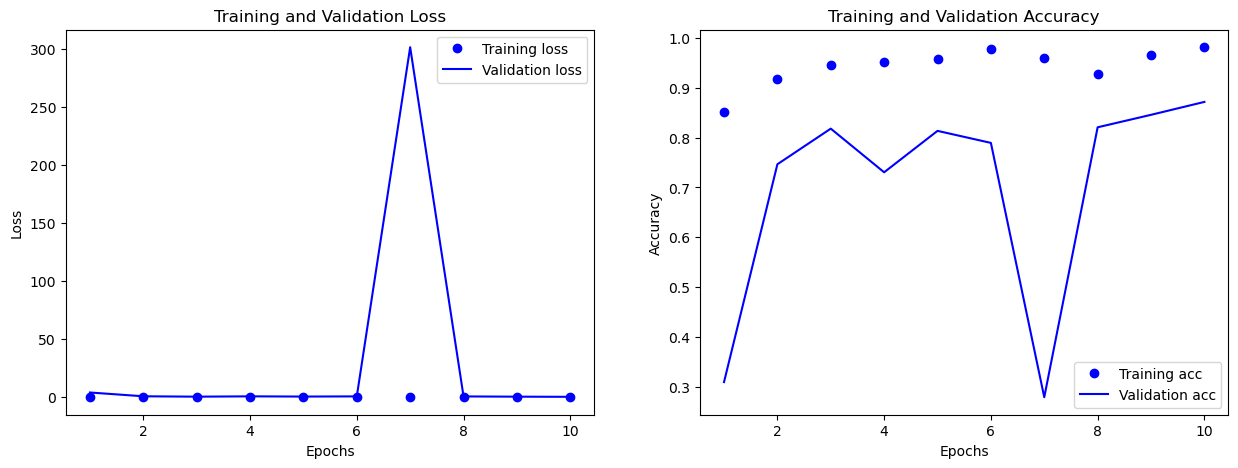

In [146]:
import matplotlib.pyplot as plt

# Evaluate the model on the test data
test_loss, test_accuracy = model_tl.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)

# Print out the accuracy
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Plot the training and validation accuracy and loss at each epoch
loss = model_tl_final.history['loss']
val_loss = model_tl_final.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.figure(figsize=(15, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
accuracy = model_tl_final.history['accuracy']
val_accuracy = model_tl_final.history['val_accuracy']
plt.plot(epochs, accuracy, 'bo', label='Training acc')
plt.plot(epochs, val_accuracy, 'b', label='Validation acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()



41/41 [==============================] - 28s 663ms/step


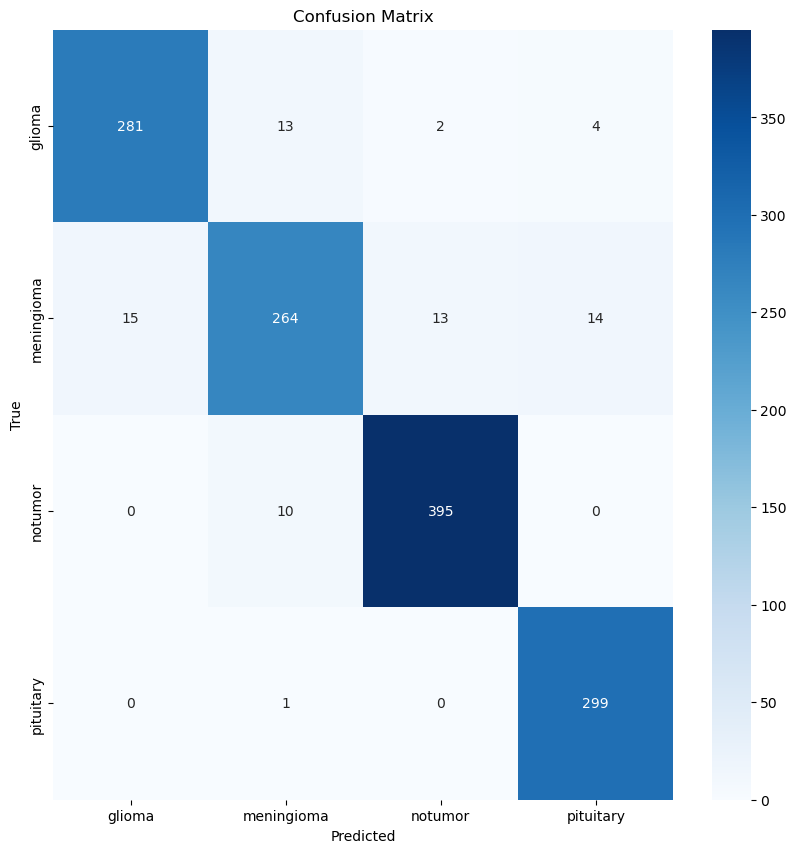

In [147]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Reset the test_generator before making predictions to ensure alignment
test_generator.reset()

# Generate predictions
predictions = model_tl.predict(test_generator, steps=np.ceil(test_generator.samples / test_generator.batch_size))

# Convert predictions to class indices
predicted_classes = np.argmax(predictions, axis=1)

# Ensure the true_classes array aligns with the predicted_classes
true_classes = test_generator.classes[:len(predicted_classes)]

# Adjust as necessary based on how your classes are defined
class_labels = list(test_generator.class_indices.keys())  

cm = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [148]:
from sklearn.metrics import classification_report

print(classification_report(true_classes, predicted_classes))

              precision    recall  f1-score   support

           0       0.95      0.94      0.94       300
           1       0.92      0.86      0.89       306
           2       0.96      0.98      0.97       405
           3       0.94      1.00      0.97       300

    accuracy                           0.95      1311
   macro avg       0.94      0.94      0.94      1311
weighted avg       0.94      0.95      0.94      1311

